# Logit Lens Analysis

In [102]:
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math

BASE_DIR = "/scratch/jp5865/overthinking_the_truth/"
sys.path.append(f"{BASE_DIR}/model")
for path in sys.path:
    print(path)

from model_params import *

sys.path.append(f"{BASE_DIR}/data")
from dataset_params import *
from prompt_params import *
from demo_params import *

/scratch/jp5865/overthinking_the_truth
/ext3/miniconda3/envs/overthinking/lib/python311.zip
/ext3/miniconda3/envs/overthinking/lib/python3.11
/ext3/miniconda3/envs/overthinking/lib/python3.11/lib-dynload

/ext3/miniconda3/envs/overthinking/lib/python3.11/site-packages
/scratch/jp5865/overthinking_the_truth//model
/scratch/jp5865/overthinking_the_truth//data
/scratch/jp5865/overthinking_the_truth//model
/scratch/jp5865/overthinking_the_truth//data
/scratch/jp5865/overthinking_the_truth//model
/scratch/jp5865/overthinking_the_truth//data
/scratch/jp5865/overthinking_the_truth//model
/scratch/jp5865/overthinking_the_truth//data
/scratch/jp5865/overthinking_the_truth//model
/scratch/jp5865/overthinking_the_truth//data
/scratch/jp5865/overthinking_the_truth//model
/scratch/jp5865/overthinking_the_truth//data
/scratch/jp5865/overthinking_the_truth//model
/scratch/jp5865/overthinking_the_truth//data
/scratch/jp5865/overthinking_the_truth//model
/scratch/jp5865/overthinking_the_truth//data
/sc

In [103]:
1+1


2

## 1) Setup

Select the parameters that you used in your script.

In [104]:
models = [
    # "gpt2_xl", 
    # "gpt_j", 
    # "gpt_neox",
    "llama_2_13b_chat",
]
datasets = [
    # "sst2",
    # "agnews",
    # "trec",
    # "dbpedia",
    # "rte",
    # "mrpc",
    # "tweet_eval_hate",
    # "sick",
    # "poem_sentiment",
    # "ethos",
    # "financial_phrasebank",
    # "medical_questions_pairs",
    # "tweet_eval_stance_feminist",
    # "tweet_eval_stance_atheism",
#     "unnatural",
#     "sst2_ab",
    "rte_overthinking_start",
    "rte_overthinking_two_before",
    "rte_overthinking_before",
    "rte_overthinking_step",
    "rte_overthinking_end",
]
settings = [
    # "permuted_incorrect_labels",
    # "half_permuted_incorrect_labels",
    # "random_labels",
    "true_labels",
]

Select the metrics that you're interested in.

In [105]:
metrics = [
    "label_space_probs",
    "top_num_labels_match",
    "top_1_acc",
    "correct_over_incorrect",
    "cal_correct_over_incorrect",
#     "cal_permute",
]

## 2) Load Results

In [106]:
results = {}
for model in models:
    results[model] = {}
    for setting in settings:
        results[model][setting] = {}
        for dataset in datasets:
            results[model][setting][dataset] = np.load(
                f"{BASE_DIR}/results/logit_lens/{model}/{setting}/{dataset}.npy",
                allow_pickle=True,
            ).item()

import pdb

In [107]:
results["gpt_j"].keys()

dict_keys(['permuted_incorrect_labels'])

In [108]:
sst2 = np.load(f"{BASE_DIR}/results/logit_lens/gpt_j/permuted_incorrect_labels/sst2.npy",
                allow_pickle=True,
            ).item()
rte = np.load(f"{BASE_DIR}/results/logit_lens/gpt_j/true_labels/rte_overthinking_before.npy",
                allow_pickle=True,
            ).item()


In [109]:
# [layer][]
len(rte["correct_over_incorrect"][0])







3

## 3) Layerwise Plots

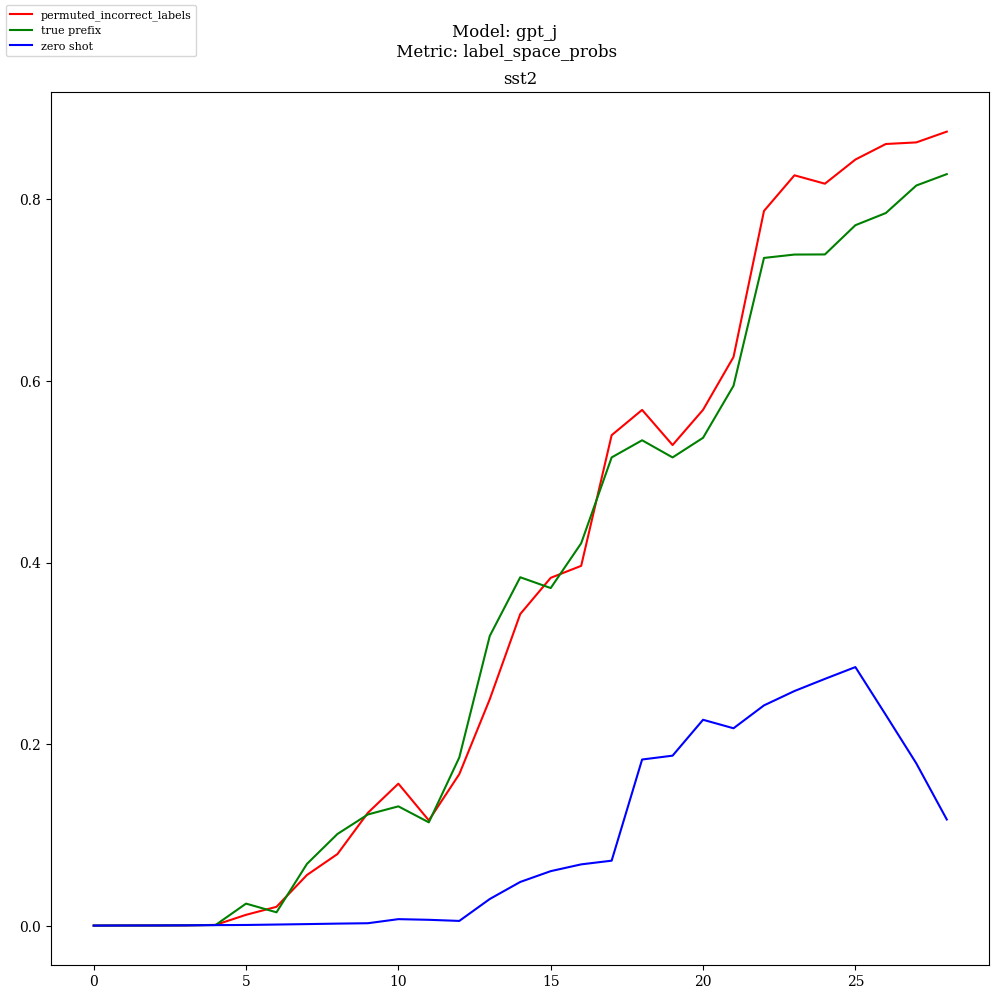

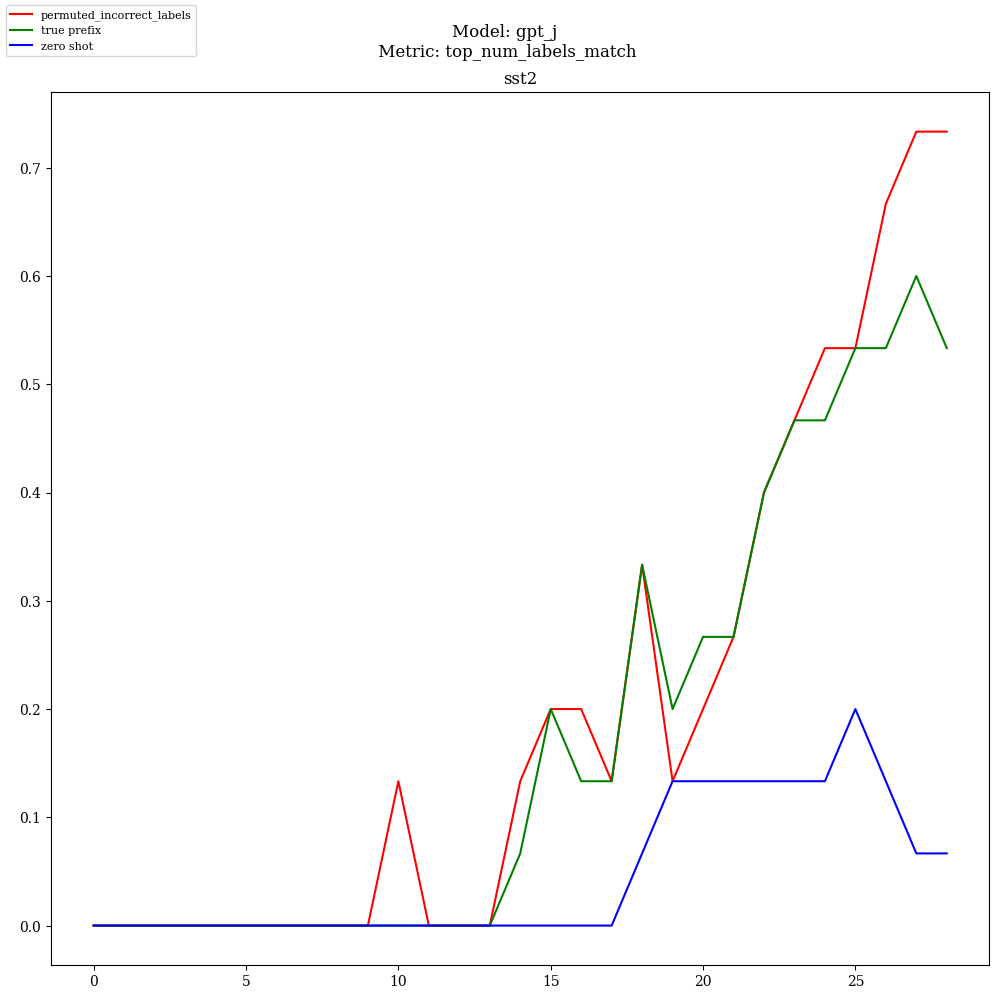

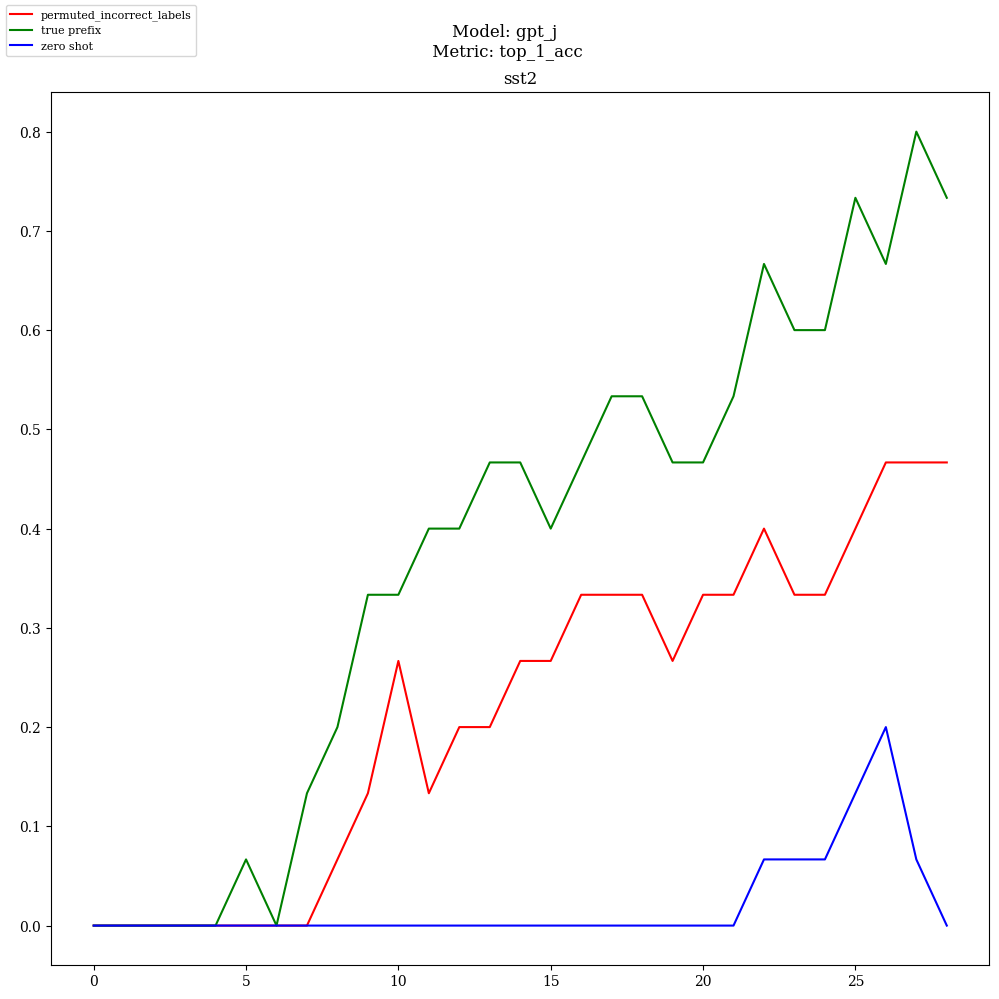

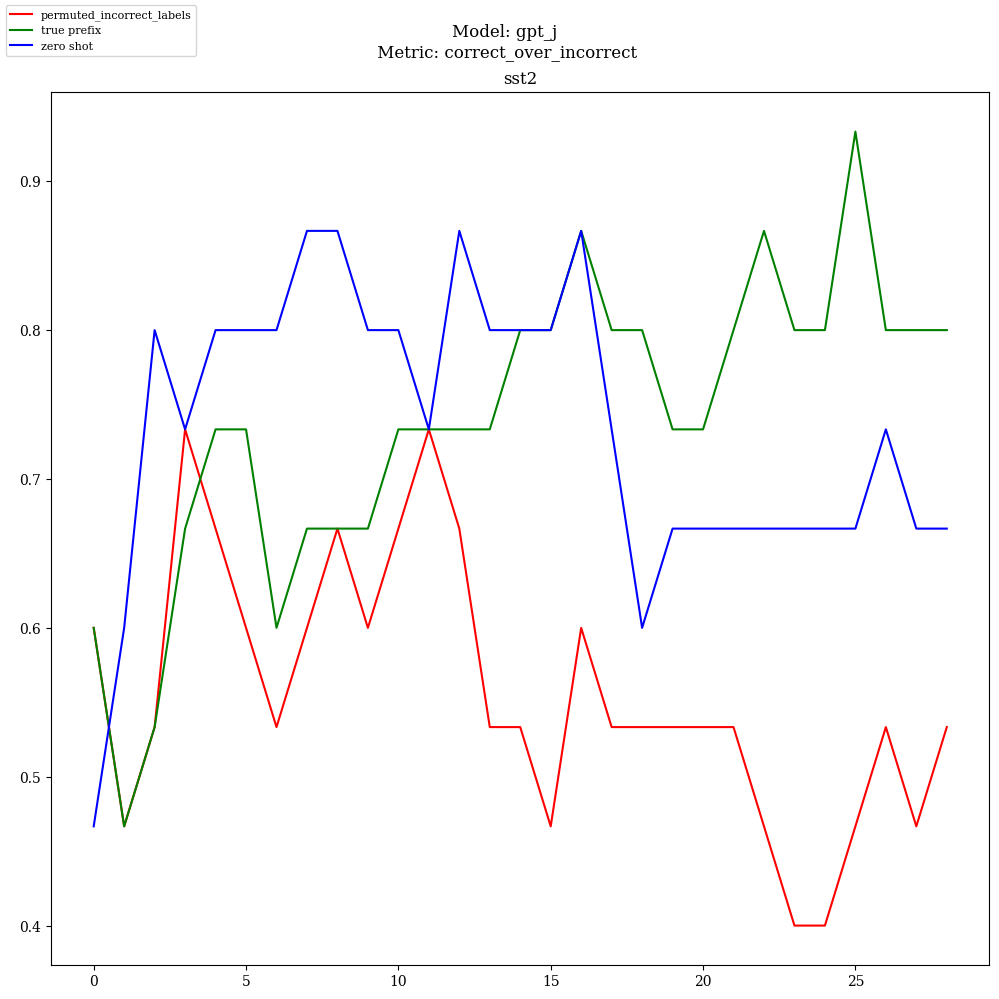

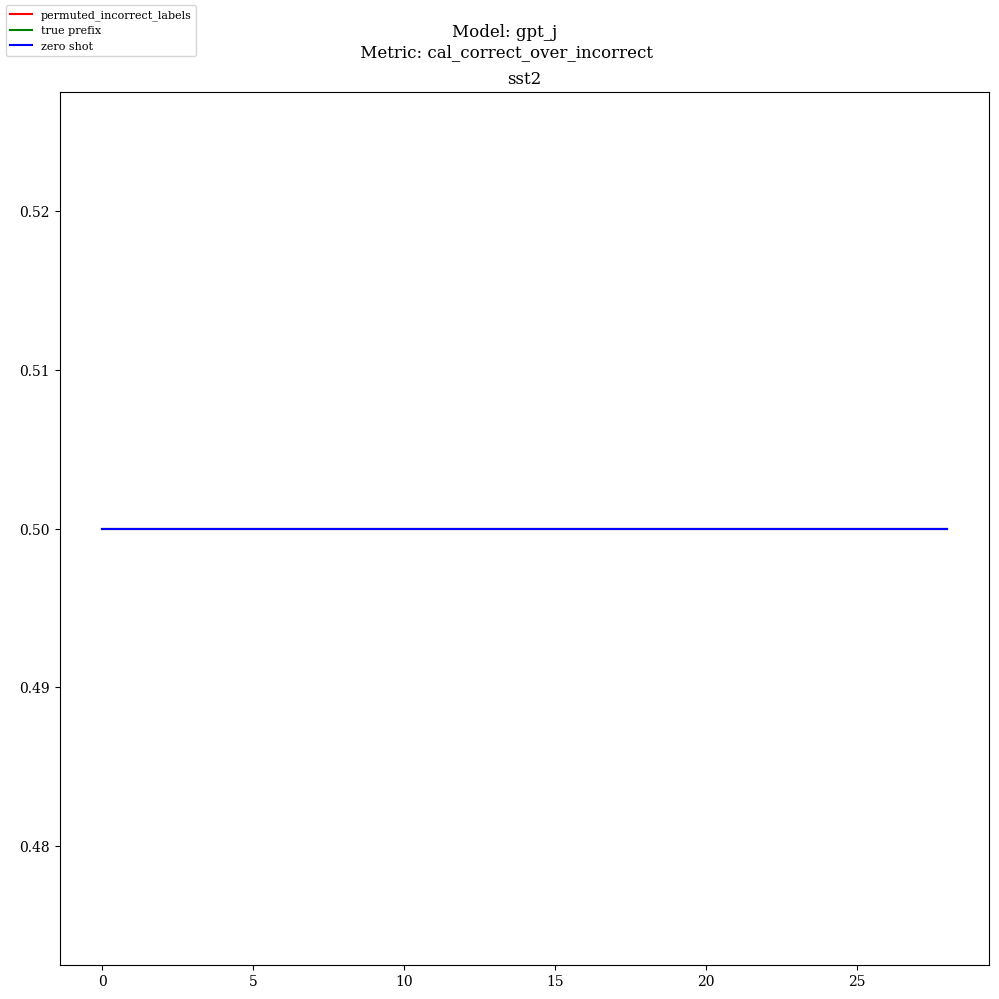

In [110]:
colors = [
    "red",
    "yellow",
    "orange",
]
plt.rcParams["font.family"] = "serif"

for model in models:
    num_layers = MODEL_PARAMS[model]["num_layers"]
    x_ax = list(range(num_layers + 1))
    for metric in metrics:
        num_subplots = len(datasets)
        grid_size = int(np.ceil(np.sqrt(num_subplots)))

        fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        fig.subplots_adjust(hspace=0.5)

        if len(datasets) == 1:  # Handle the case when there's only one dataset
            axs = np.array([[axs]])  # Wrap axs in an extra list

        for ax, dataset in zip(axs.flat, datasets):
            for j, setting in enumerate(settings):
                y = np.mean(results[model][setting][dataset][metric], axis=0)[0]
                y_ax = y[1, :, -1]
                ax.plot(x_ax, y_ax, color=colors[j])
            # true prefix
            y_ax = y[0, :, -1]
            ax.plot(x_ax, y_ax, "green")
            # zero shot
            y_ax = y[0, :, 0]
            ax.plot(x_ax, y_ax, color="blue")
            ax.set_title(f"{dataset}")

        for ax in axs.flat[len(datasets) :]:
            ax.set_visible(False)

        fig.suptitle(f"Model: {model}\n Metric: {metric}", fontsize=12)
        fig.legend(
            settings + ["true prefix", "zero shot"],
            ncol=1,
            loc="upper left",
            fontsize=8,
        )

        fig.tight_layout()
        plt.show()

## 4) Critical Layers

In [111]:
setting = "permuted_incorrect_labels"
critical_layers = {}
for model in models:
    num_layers = MODEL_PARAMS[model]["num_layers"]
    early_exit = [0] * num_layers
    for metric in metrics:
        for dataset in datasets:
            res_avg = np.mean(results[model][setting][dataset][metric], axis=0)[0]
            for layer in range(num_layers):
                early_exit[layer] += res_avg[1, layer, -1] - res_avg[1, -1, -1]
    max_value = max(early_exit)
    max_index = early_exit.index(max_value)
    critical_layers[model] = max_index

print("*Critical Layers*")
print(critical_layers)

*Critical Layers*
{'gpt_j': 27}


In [112]:
with open('../../results/critical_layers/critical_layers.pkl', 'wb') as file:
    pickle.dump(critical_layers, file)

FileNotFoundError: [Errno 2] No such file or directory: '../../results/critical_layers/critical_layers.pkl'

In [ ]:
print("*Early Exit Average Performance*\n")
for setting in settings:
    print(f"Setting: {setting}")
    for model in models:
        crit_lay = critical_layers[model]
        print(f"Model: {model}")
        for metric in metrics:
            tp_diff = fp_diff = 0
            for dataset in datasets:
                res_avg = np.mean(results[model][setting][dataset][metric], axis=0)[0]
                tp_diff += res_avg[0, crit_lay, -1] - res_avg[0, -1, -1]
                fp_diff += res_avg[1, crit_lay, -1] - res_avg[1, -1, -1]
            tp_diff_avg = (tp_diff / len(datasets)) * 100
            fp_diff_avg = (fp_diff / len(datasets)) * 100
            print(f"True Prefix Delta: {tp_diff_avg:.{3}f}%")
            print(f"False Prefix Delta: {fp_diff_avg:.{3}f}%")
    print()

: 

## 5) Gap Emergence

In [ ]:
print("*Gap Emergence: 50% of Final Layer Gap*")
setting = "permuted_incorrect_labels"
for model in models:
    print(f"Model: {model}")
    num_layers = MODEL_PARAMS[model]["num_layers"]
    for metric in metrics:
        for dataset in datasets:
            demo_indx = MODEL_PARAMS[model]["max_demos"] - 1
            res_avg = np.mean(results[model][setting][dataset][metric], axis=0)[0]
            tp = res_avg[0, :, demo_indx]
            fp = res_avg[1, :, demo_indx]
            final_gap = tp[-1] - fp[-1]
            layer = np.argmax((tp - fp) / final_gap >= 0.50)
            print(f"Layer: {layer:02}. Dataset: {dataset}.")
        print()

: 